### Import Libraries

In [47]:
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam

### Load Data

In [2]:
dataset = np.load("../data/features/gi_ds_pr20_br20_rt1_rt2_s.npy")
dataset.shape

(5992, 399)

In [ ]:
X = dataset[:, :-1]
y = dataset[:, -1]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (5992, 398)
y shape: (5992,)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print("X Train shape:", X_train.shape)
print("y Train shape:", y_train.shape)
print("X Test shape:", X_test.shape)
print("y Test shape:", y_test.shape)

X Train shape: (5392, 398)
y Train shape: (5392,)
X Test shape: (600, 398)
y Test shape: (600,)


### Modeling

In [21]:
def build_model(hp):
  model = Sequential()
  model.add(Input(shape=(398,)))

  # hidden layer 1 with l2
  if hp.Boolean("layer1_use_l2"):
    l2 = hp.Choice("l2_1", [1e-1, 1e-2, 1e-3, 1e-4])
    model.add(
      Dense(
        units=hp.Choice("units1", [64, 128, 256, 512]),
        kernel_regularizer=L2(l2), activation="relu"
      )
    )
  else:
    model.add(
      Dense(units=hp.Choice("units1", [64, 128, 256, 512]), activation="relu")
    )

  # dropout layer 1 (optional)
  if hp.Boolean("use_dropout1"):
    model.add(
      Dropout(hp.Float('dropout1', min_value=0.1, max_value=0.3, step=0.1))
    )

  # hidden layer 2 with l2
  if hp.Boolean("layer2_use_l2"):
    l2 = hp.Choice("l2_2", [1e-1, 1e-2, 1e-3, 1e-4])
    model.add(
      Dense(
        units=hp.Choice("units2", [64, 128, 256, 512]),
        kernel_regularizer=L2(l2), activation="relu"
      )
    )
  else:
    model.add(
      Dense(units=hp.Choice("units2", [64, 128, 256, 512]), activation="relu")
    )

  # dropout layer 2 (optional)
  if hp.Boolean("use_dropout2"):
    model.add(
      Dropout(hp.Float('dropout2', min_value=0.1, max_value=0.3, step=0.1))
    )

  # output layer
  model.add(Dense(128, activation="softmax"))

  # optimizer and learning rate
  lr = hp.Choice("learning_rate", [1e-1, 1e-2, 1e-3, 1e-4])
  optimizer = Adam(learning_rate=lr)

  model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", SparseTopKCategoricalAccuracy(k=5)]
  )

  return model

In [33]:
tuner = kt.RandomSearch(
  build_model,
  objective="val_accuracy",
  max_trials=50,
  executions_per_trial=1,
  directory="../tuning_dir",
  project_name="ann_allstep_2layers_l2_dropout"
)

In [34]:
tuner.search(X_train, y_train, epochs=100, validation_split=0.1)

Trial 50 Complete [00h 03m 00s]
val_accuracy: 0.040740739554166794

Best val_accuracy So Far: 0.16111111640930176
Total elapsed time: 02h 00m 39s


In [35]:
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]

print("Best trial ID:", best_trial.trial_id)
print("Best val_accuracy:", best_trial.score)
print("Best hyperparameters:", best_trial.hyperparameters.values)


Best trial ID: 26
Best val_accuracy: 0.16111111640930176
Best hyperparameters: {'layer1_use_l2': False, 'units1': 64, 'use_dropout1': False, 'layer2_use_l2': True, 'units2': 128, 'use_dropout2': False, 'learning_rate': 0.001, 'l2_2': 0.001, 'dropout2': 0.2, 'l2_1': 0.001, 'dropout1': 0.1}


In [36]:
best_model = tuner.get_best_models()[0]
best_hps = tuner.get_best_hyperparameters()[0]

best_model.evaluate(X_test, y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1232 - loss: 4.5073 - sparse_top_k_categorical_accuracy: 0.4086


[4.560497283935547, 0.12666666507720947, 0.3933333456516266]

### Best Hyperparameters

In [45]:
best_hp = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hp)

In [46]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100)

Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0290 - loss: 4.5656 - sparse_top_k_categorical_accuracy: 0.1276 - val_accuracy: 0.0399 - val_loss: 4.0691 - val_sparse_top_k_categorical_accuracy: 0.1881
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0598 - loss: 3.8863 - sparse_top_k_categorical_accuracy: 0.2499 - val_accuracy: 0.0417 - val_loss: 3.9043 - val_sparse_top_k_categorical_accuracy: 0.2243
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0750 - loss: 3.7624 - sparse_top_k_categorical_accuracy: 0.2883 - val_accuracy: 0.0686 - val_loss: 3.8100 - val_sparse_top_k_categorical_accuracy: 0.2660
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0822 - loss: 3.6647 - sparse_top_k_categorical_accuracy: 0.3157 - val_accuracy: 0.0741 - val_loss: 3.7665 - val_sparse_top_k_categorical_accuracy: 0.2753
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1135 - loss: 3.5509 - sparse_top_k_categorical_ac

In [64]:
model.evaluate(X_test, y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1253 - loss: 5.4570 - sparse_top_k_categorical_accuracy: 0.3667


[5.398202419281006, 0.125, 0.3683333396911621]

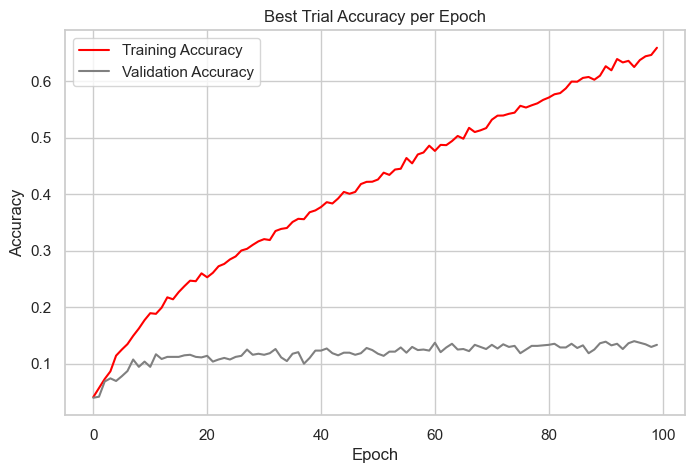

In [59]:
sns.set_theme(style="whitegrid", palette="RdGy")

plt.figure(figsize=(8, 5))
sns.lineplot(history.history["accuracy"], label="Training Accuracy", color="Red")
sns.lineplot(history.history["val_accuracy"], label="Validation Accuracy", color="Gray")
plt.title("Best Trial Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


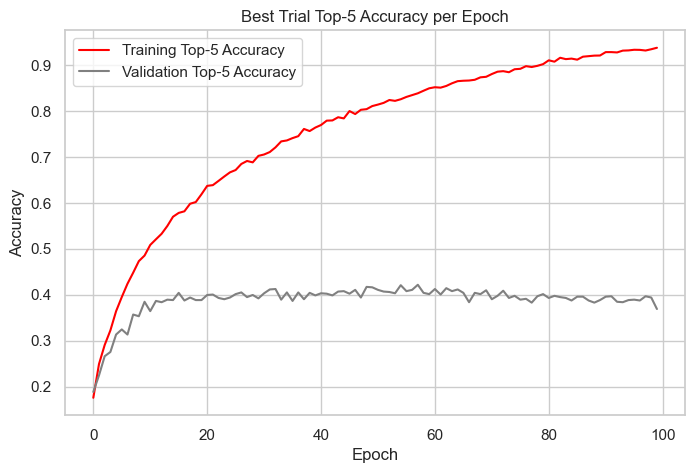

In [61]:
plt.figure(figsize=(8, 5))
sns.lineplot(history.history["sparse_top_k_categorical_accuracy"], label="Training Top-5 Accuracy", color="Red")
sns.lineplot(history.history["val_sparse_top_k_categorical_accuracy"], label="Validation Top-5 Accuracy", color="Gray")
plt.title("Best Trial Top-5 Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

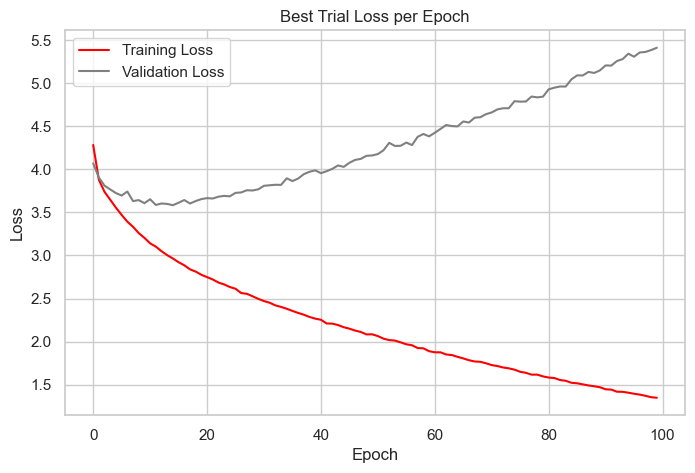

In [63]:
plt.figure(figsize=(8, 5))
sns.lineplot(history.history["loss"], label="Training Loss", color="Red")
sns.lineplot(history.history["val_loss"], label="Validation Loss", color="Gray")
plt.title("Best Trial Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()